In [1]:
# Description: Plot Figure 4 (Cross-stream PV profile of the Cape Horn shelfbreak jet and example solutions for the geostrophic adjustment models).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        May/2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from xarray import open_dataset
from cmocean.cm import thermal

In [3]:
def sol_onehalflay_nooutcrop(x, Ldl, Ldr, Hl, Hr, gp, f):
    Ldw = Ldl + Ldr
    DeltaH = Hr - Hl
    prefach = DeltaH/Ldw
    prefacv = prefach*gp/f

    hl = + Ldl*prefach*np.exp(+x/Ldl) + Hl
    hr = - Ldr*prefach*np.exp(-x/Ldr) + Hr
    vl = + prefacv*np.exp(+x/Ldl)
    vr = + prefacv*np.exp(-x/Ldr)

    fl, fr = x <= 0, x > 0
    hl[fr] = 0
    hr[fl] = 0
    vl[fr] = 0
    vr[fl] = 0
    h = hl + hr
    v = vl + vr

    return h, v


def sol_twohalflay_outcrop(x, H1r, H2r, H2l, gp1, gp2, f):
    L1r = np.sqrt(gp1*H1r)/f
    L2r = np.sqrt(gp2*H2r)/f
    L2l = np.sqrt(gp2*H2l)/f
    print("L1r = %1.1f km"%(L1r/1e3))
    print("L2r, L2l = %1.1f, %1.1f km"%(L2r/1e3, L2l/1e3))
    DH2 = H2r - H2l
    Gp = 1 + gp2/gp1

    sqrt2 = np.sqrt(2)
    Llrsq = 4*(L1r/L2r)**2
    a1m = np.sqrt((Gp - np.sqrt(Gp + Llrsq)))/sqrt2
    a1p = np.sqrt((Gp + np.sqrt(Gp + Llrsq)))/sqrt2
    a2m = np.sqrt((Gp - np.sqrt(Gp - Llrsq)))/sqrt2
    a2p = np.sqrt((Gp + np.sqrt(Gp - Llrsq)))/sqrt2

    A1r = + H1r*a1m/(a1p - a1m)
    B1r = - H1r*a1p/(a1p - a1m)
    A2rnum = DH2*a2p * (L1r*a2m*(a1p + a1m) + a1p*a1m*(L2l*a2m - L2r))
    A2rden = a1p*a1m * (L2l*a2p**2 - L2l*a2p*a2m + L2r*a2p - L2r*a2m)
    A2r = A2rnum/A2rden
    B2rnum = DH2*a2m * (-L1r*a2p*(a1p + a1m) - a1p*a1m*(L2l*a2p - L2r))
    B2rden = a1p*a1m * (L2l*a2p*a2m - L2l*a2m**2 + L2r*a2p - L2r*a2m)
    B2r = B2rnum/B2rden
    A2lnum = DH2*L2l * (-L1r*a2p*a2m*(a1p + a1m) + L2r*a1p*a1m*(a2p + a2m))
    A2lden = a1p*a1m * (a2p*a2m*L2l**2 + L2l*L2r*(a2m + a2p) + L2r**2)
    A2l = A2lnum/A2lden
    d = (A1r/a1p + B1r/a1m)*L1r/H1r
    xp = x - d

    # Solutions for h1r(x), v1r(x), h2r(x), v2r(x), h2l(x), v2l(x).
    h2l = A2l*np.exp(xp/L2l) + H2l
    h2r = A2r*np.exp(-a2p*xp/L2r) + B2r*np.exp(-a2m*xp/L2r) + H2r
    h1r = A1r*np.exp(-a1p*xp/L1r) + B1r*np.exp(-a1m*xp/L1r) + H1r

    v2l = (A2l/L2l)*(gp2/f)*np.exp(xp/L2l)
    T1v = (A1r*a1p*np.exp(-a1p*xp/L1r) + B1r*a1m*np.exp(-a1m*xp/L1r))/L1r
    T2v = (A2r*a2p*np.exp(-a2p*xp/L2r) + B2r*a2m*np.exp(-a2m*xp/L2r))/L2r
    v2r = - (gp2/f)*(T1v + T2v)
    v1r = v2r - (gp1/f)*T1v

    fl, fr = xp <= 0, xp > 0
    h2l[fr] = np.nan
    h1r[fl] = np.nan
    h2r[fl] = np.nan
    v1r[fl] = np.nan
    v2r[fl] = np.nan
    v2l[fr] = np.nan

    return h1r, h2r, v1r, v2r, h2l, v2l, d, L1r, L2r, L2l

In [4]:
f = "../../data/derived/ustream_shelbreakjet_LMG.nc"

ds = open_dataset(f)
Tsmean = ds["T"].values
xs = ds["x"].values
z = ds["z"].values
PVfac = 1e6
PV0 = ds["PV0"].values*PVfac
PVx = ds["PVx"].values*PVfac
PVz = ds["PVz"].values*PVfac
PV = ds["PV"].values*PVfac

xsclip = 30
TccXBT = np.arange(4, 8, 0.5)
wspace = 0.1

# Get shallow water PV inversion solutions.
Lx = 300e3  # [m]
gp = 1.4e-2 # [m/s2]
f = 9e-5    # [1/s]

# For the Gulf Stream at the Oleander line, from Rossby & Zhang (2001), Fig. 12
Hl = 200   # [m]
Hr = 700   # [m]

# Rossby & Zhang (2001) obtain Ldl = 19.7 and Ldr = 34.3 km from the normal modes eigenvalue problem using the Oleander XBTs profiles.
Ldl = np.sqrt(gp*Hl)/f
Ldr = np.sqrt(gp*Hr)/f

xl, xr = -Lx/2, Lx/2
x = np.linspace(xl, xr, num=10000)
xkm, xlkm, xrkm = x*1e-3, xl*1e-3, xr*1e-3

h, v = sol_onehalflay_nooutcrop(x, Ldl, Ldr, Hl, Hr, gp, f)

hIC = h.copy()
hIC[x<0] = Hl
hIC[x>0] = Hr
hIC[x==0] = np.nan

# 2.5 layer case with one outcrop.
g = 9.81
rho1, rho2, rho3 = 1024, 1025, 1026
rho1, rho2, rho3 = 1024, 1024.5, 1025
gp1 = g*(rho2 - rho1)/rho2
gp2 = g*(rho3 - rho2)/rho3
# gp1 = 1e-2 # [m/s2]
# gp2 = 1e-2 # [m/s2]
H1r = 150 #100#H2l    # [m]
H2l = 150    # [m]
H2r = 600    # [m]

# Rossby & Zhang (2001) obtain Ldl = 19.7 and Ldr = 34.3 km from the normal modes eigenvalue problem using the Oleander XBTs profiles.
h1r, h2r, v1r, v2r, h2l, v2l, d, L1r, L2r, L2l = sol_twohalflay_outcrop(x, H1r, H2r, H2l, gp1, gp2, f)

L1r = 9.4 km
L2r, L2l = 18.8, 9.4 km


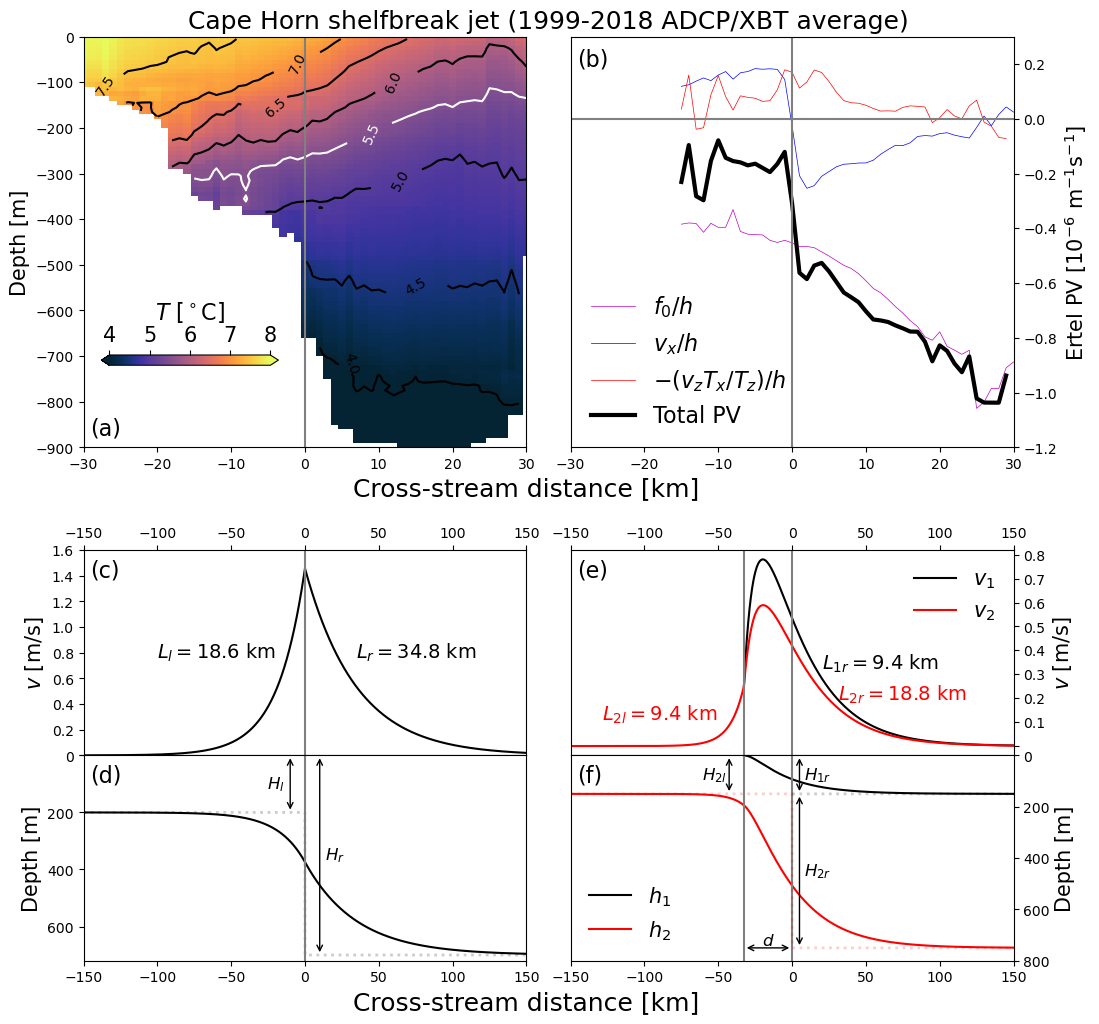

In [5]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, hspace=0.25, wspace=wspace)
gsuu = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:2], wspace=wspace)
gsll = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[2], hspace=0)
gslr = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[3], hspace=0)

ax1 = fig.add_subplot(gsuu[0])
ax2 = fig.add_subplot(gsuu[1], sharex=ax1)
ax3 = fig.add_subplot(gsll[0])
ax4 = fig.add_subplot(gsll[1], sharex=ax3)
ax5 = fig.add_subplot(gslr[0], sharex=ax3)
ax6 = fig.add_subplot(gslr[1], sharex=ax3)

T0 = float(ds.attrs["bounding_isotherm_for_lower_PV_layer"][:-4])
TccXBT = TccXBT.tolist()
TccXBT.remove(T0)
cs = ax1.pcolormesh(xs, z, Tsmean, vmin=4, vmax=8, cmap=thermal)
cc = ax1.contour(xs, z, Tsmean, levels=TccXBT, colors="k")
ax1.clabel(cc, inline_spacing=0)
cc = ax1.contour(xs, z, Tsmean, levels=[T0], colors="w", linewidths=1.5)
ax1.clabel(cc, inline_spacing=0)
ax1.set_xlim(-xsclip, xsclip)
ax1.axvline(x=0, color="gray", linestyle="solid")
ax1.set_xlabel("Cross-stream distance [km]", fontsize=18, x=1)
ax1.set_ylabel("Depth [m]", fontsize=15)
ax1.set_title("Cape Horn shelfbreak jet (1999-2018 ADCP/XBT average)", fontsize=18, x=1.05)

cax = ax1.inset_axes([0.04, 0.2, 0.4, 0.025])
cb = fig.colorbar(cs, cax=cax, orientation="horizontal", extend="both")
cb.set_label(r"$T$ [$^\circ$C]", fontsize=16)
cb.ax.xaxis.set_ticks(np.arange(4, 9, 1))
cb.ax.xaxis.set_ticks_position("top"); cb.ax.xaxis.set_label_position("top")
cb.ax.xaxis.set_tick_params(labelsize=15)

ax2.yaxis.set_ticks_position("right"); ax2.yaxis.set_label_position("right")
ax2.yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
ax2.plot(xs, PV0, "m", linewidth=0.5, label="$f_0/h$")
ax2.plot(xs, PVx, "b", linewidth=0.5, label="$v_x/h$")
ax2.plot(xs, PVz, "r", linewidth=0.5, label="$-(v_z T_x/T_z)/h$")
ax2.plot(xs, PV, "k", linewidth=3, label="Total PV")
ax2.set_ylim(-1.2, 0.3)
ax2.axhline(y=0, color="gray", linestyle="solid")
ax2.axvline(x=0, color="gray", linestyle="solid")
ax2.legend(frameon=False, fontsize=16)
ax2.set_ylabel("Ertel PV [$10^{-%d}$ m$^{-1}$s$^{-1}$]"%int(np.log10(PVfac)), fontsize=15)

ax3.xaxis.tick_top()
ax3.xaxis.set_label_position("top")
ax5.xaxis.tick_top()
ax5.xaxis.set_label_position("top")

maxv = np.round(v.max(), 2) + 0.05
ax3.plot(xkm, v, "k")
ax3.set_xlim(xlkm, xrkm)
ax3.set_ylim(0, maxv)
ax3.axvline(color="gray", linestyle="solid")
ax3.set_ylabel("$v$ [m/s]", fontsize=15)

vtks = np.arange(0, maxv + 0.2, 0.2)
ax3.set_yticks(vtks)
# Important to render initial ytick labels.
fig.canvas.draw()
ytkls = [txt.get_text() for txt in ax3.get_yticklabels()]
ytkls[0] = ""
ax3.set_yticklabels(ytkls)

ax4.plot(xkm, hIC, "k:", alpha=0.2, linewidth=2) # Step IC.
ax4.plot(xkm, h, "k")
ax4.set_xlim(xlkm, xrkm)
ax4.set_ylim(0, Hr + 20)
ax4.invert_yaxis()
ax4.axvline(color="gray", linestyle="solid")
ax4.set_xlabel("Cross-stream distance [km]", fontsize=18, x=1)
ax4.set_ylabel("Depth [m]", fontsize=15)

# Annotations.
xtl, xtr, yt = 0.3, 0.75, 0.5
ax3.text(xtl, yt, "$L_l = %1.1f$ km"%(Ldl/1e3), fontsize=14, ha="center", va="center", transform=ax3.transAxes)
ax3.text(xtr, yt, "$L_r = %1.1f$ km"%(Ldr/1e3), fontsize=14, ha="center", va="center", transform=ax3.transAxes)

ax4.text(-20, Hl/2, "$H_l$", fontsize=12, ha="center", va="center")
ax4.text(20, Hr/2, "$H_r$", fontsize=12, ha="center", va="center")

ax4.annotate("", xy=(-10, 0), xycoords="data",
                 xytext=(-10, Hl), textcoords="data",
                 arrowprops=dict(arrowstyle="<->",
                 connectionstyle="arc3"))

ax4.annotate("", xy=(10, 0), xycoords="data",
                 xytext=(10, Hr), textcoords="data",
                 arrowprops=dict(arrowstyle="<->",
                 connectionstyle="arc3"))

ax5.yaxis.set_ticks_position("right"); ax5.yaxis.set_label_position("right")
ax5.yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
ax6.yaxis.set_ticks_position("right"); ax6.yaxis.set_label_position("right")
ax6.yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)

maxv = np.round(np.nanmax(v1r), 2) + 0.05
vtks = np.arange(0, maxv + 0.1, 0.1)
ax5.set_yticks(vtks)
# Important to render initial ytick labels.
fig.canvas.draw()
ytkls = [txt.get_text() for txt in ax5.get_yticklabels()]
ytkls[0] = ""
ax5.set_yticklabels(ytkls)

ax6.plot(xkm, h1r, "k", label="$h_1$")
ax6.plot(xkm, h2l, "r", label="$h_2$")
ax6.plot(xkm, h2r + h1r, "r") # Add thickness of overlying layer just for plotting.
ax6.set_xlim(xlkm, xrkm)
ax6.axvline(color="gray", linestyle="solid")
ax6.axvline(d/1e3, color="gray", linestyle="solid")
ax6.set_ylim(0, H1r + H2r + 50)
ax6.invert_yaxis()
ax6.legend(fontsize=15, frameon=False)
ax6.set_ylabel("Depth [m]", fontsize=15)

ax5.plot(xkm, v1r, "k", label="$v_1$")
ax5.plot(xkm, v2r, "r", label="$v_2$")
ax5.plot(xkm, v2l, "r")
ax5.set_xlim(xlkm, xrkm)
ax5.axvline(color="gray", linestyle="solid")
ax5.axvline(d/1e3, color="gray", linestyle="solid")
ax5.legend(fontsize=15, frameon=False)
ax5.set_ylabel("$v$ [m/s]", fontsize=15)

# Annotations.
h1IC = h1r.copy()
h1IC[x<0] = np.nan
h1IC[x>0] = H1r
h2IC = h1r.copy()
h2IC[x<0] = H2l
h2IC[x>0] = H2r + H2l # Add thickness of overlying layer just for plotting.

# Step PV IC.
ax6.plot(xkm, h1IC, "k:", alpha=0.2, linewidth=2)
ax6.plot(xkm, h2IC, "r:", alpha=0.2, linewidth=2)

xtl, xtr, yt = 0.2, 0.75, 0.2
ax5.text(xtl, yt, "$L_{2l} = %1.1f$ km"%(L2l/1e3), fontsize=14, color="r", ha="center", va="center", transform=ax5.transAxes)
ax5.text(xtr, yt+0.1, "$L_{2r} = %1.1f$ km"%(L2r/1e3), fontsize=14, color="r", ha="center", va="center", transform=ax5.transAxes)
ax5.text(xtr-0.05, yt+0.25, "$L_{1r} = %1.1f$ km"%(L1r/1e3), fontsize=14, color="k", ha="center", va="center", transform=ax5.transAxes)
ax6.text(d/1e3 - 20, H2l/2, "$H_{2l}$", fontsize=12, ha="center", va="center")
ax6.text(17, H1r/2, "$H_{1r}$", fontsize=12, ha="center", va="center")
ax6.text(17, H1r + H2r/2, "$H_{2r}$", fontsize=12, ha="center", va="center")
ax6.text(d*1e-3/2, H1r + H2r - 30, "$d$", fontsize=12, ha="center", va="center")

ax6.annotate("", xy=(d/1e3 - 10, 0), xycoords="data",
                 xytext=(d/1e3 - 10, H2l), textcoords="data",
                 arrowprops=dict(arrowstyle="<->",
                 connectionstyle="arc3"))

ax6.annotate("", xy=(5, 0), xycoords="data",
                 xytext=(5, H1r), textcoords="data",
                 arrowprops=dict(arrowstyle="<->",
                 connectionstyle="arc3"))

ax6.annotate("", xy=(5, H1r), xycoords="data",
                 xytext=(5, H1r + H2r), textcoords="data",
                 arrowprops=dict(arrowstyle="<->",
                 connectionstyle="arc3"))

ax6.annotate("", xy=(d*1e-3, H1r + H2r), xycoords="data",
                 xytext=(0, H1r + H2r), textcoords="data",
                 arrowprops=dict(arrowstyle="<->",
                 connectionstyle="arc3"))

ax1.text(0.015, 0.03, "(a)", fontsize=16, transform=ax1.transAxes)
ax2.text(0.015, 0.93, "(b)", fontsize=16, transform=ax2.transAxes)
ax3.text(0.015, 0.87, "(c)", fontsize=16, transform=ax3.transAxes)
ax4.text(0.015, 0.87, "(d)", fontsize=16, transform=ax4.transAxes)
ax5.text(0.015, 0.87, "(e)", fontsize=16, transform=ax5.transAxes)
ax6.text(0.015, 0.87, "(f)", fontsize=16, transform=ax6.transAxes);

In [6]:
fig.savefig("fig04.png", bbox_inches="tight", dpi=150)